# Train an agent to play FrozenLake using Q-learning


[Gymnasium](https://gymnasium.farama.org) is a toolkit for developing and comparing reinforcement algorithms. It contains several test problem (*environments*) that have a shared interface, allowing you to write general algorithms. 

Let's start with importing all necessary dependencies.

In [11]:
%python -m pip install gym

UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [1]:
import gym
import numpy as np
import random
from enum import Enum

In [3]:
!uv add 'gymnasium[classic-control]'

Resolved 129 packages in 517ms                                       
Audited 124 packages in 0.15ms                                       


One of the environments Gym contains is FrozenLake.

    Winter is here. You and your friends were tossing around a frisbee at the
    park when you made a wild throw that left the frisbee out in the middle of
    the lake. The water is mostly frozen, but there are a few holes where the
    ice has melted. If you step into one of those holes, you'll fall into the
    freezing water. At this time, there's an international frisbee shortage, so
    it's absolutely imperative that you navigate across the lake and retrieve
    the disc. However, the ice is slippery, so you won't always move in the
    direction you intend.
    The surface is described using a grid like the following
 
        SFFF
        FHFH
        FFFH
        HFFG
 
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
 
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

More info on: https://gymnasium.farama.org/environments/toy_text/frozen_lake/

Let's start and create the environment.

In [4]:
env = gym.make("FrozenLake-v1", is_slippery=False)

## Initialize the Q-table 

Remember: 
- number of rows: number of states
- number of columns: number of actions
q-table: np array of dimension (states, actions)

add some things on how to make np arrays

In [5]:
state_space_size = env.observation_space.n
action_space_size = env.action_space.n

In [6]:
q_table = np.zeros((state_space_size, action_space_size))

In [7]:
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## Set the hyperparameters

In this section we will initialize the hyperparameters. 

The first one is the *discount factor*. This is a number in [0,1] indicating how much the agent cares about rewards in the future relative to those in the immediate future. 

In [8]:
discount_factor = 0.99

The second parameter is the *learning rate*. This is a number in [0,1] indicating how quickly the agent will adopt the new (learned) Q-value. 

In [9]:
learning_rate = 0.1

Finally we set the necessary parameters to deal with the trade-off between exploration and exploitation. We have to set
- *initial exploration rate*: upper bound for the exploration rate and initial exploration rate, we will use this to update the exploration rate
- *minimum exploration rate*: lower bound for the exploration rate, by setting it to a value greater than 0, we make sure there is always a probability for exploration
- *exploration rate*: probability that the agent will explore, will be updated after each episode, using exponential decay: 
$$N(t) = N_0 e^{-\lambda t}$$
where $N_0$ is the initial quantity, $N(t)$ is the quantity at time step $t$ and $\lambda$ is the rate of decay.
- *exploration rate decay*: how fast or slow does the exploration rate decay

In [10]:
initial_exploration_rate = 1
min_exploration_rate = 0.01
exploration_rate = 1
exploration_decay_rate = 0.001

We also set number of episodes and maximum number of steps per episode.

In [11]:
num_episodes = 10000
max_steps_per_episode = 100

## Train the agent

Store the total rewards for each episode. This is for diagnostics.

If an episode is succesfull this translate to reward 1 if not to reward 0, so we can use this array to check % of successes

In [12]:
rewards = np.zeros(num_episodes) 

In each episode:
1.   Reset environment
2.   For each step in the episode:
  - pick an action $a$ by generating a random float $r$ in $[0,1]$
    - if $r > \epsilon$ we choose the next action by exploitation
    - if $r \leq \epsilon$ we choose the next action by exploration
  - take action $a$ and observe reward $R$ and next state $s'$
  - update Q-table 
  $$ q(s,a) = q(s,a) + \alpha(R + \gamma max_{a'} q(s', a') - q(s,a)) $$
3. decrease exploration rate proportional to its current value, we will use exponential decay: 
$$N(t) = N_0 e^{-\lambda t}$$
where $N_0$ is the initial quantity and $N(t)$ is the quantity at time step $t$.



with 
- $\epsilon$ the exploration rate,
- $\lambda$ the exploration rate decay,
- $\alpha$ the learning rate and 
- $\gamma$ the discount factor.









In [13]:
for episode in range(num_episodes):
    state = env.reset()[0] # start with a clean slate
    reward_episode = 0 # keep track of total reward for this episode

    for step in range(max_steps_per_episode):
        # exploration or exploitation? -> we need to pick a random float in 0 and 1
        exploration_rate_treshold = random.uniform(0,1)
        if exploration_rate_treshold > exploration_rate:
            action = np.argmax(q_table[state]) #exploitation: look in row "state" which column "action" has the highest value
        else:
            action = env.action_space.sample() #exploration: random action

        # take a step in the environment: let's store the new state under a new name since we still need to use the old state
        new_state, reward, terminated, truncated , info = env.step(action)
        
        # terminated = True if environment terminates (eg. due to task completion, failure etc.)
        # truncated = True if episode truncates due to a time limit or a reason that is not defined as part of the task.
        done = truncated or terminated 

        # update q-table for current (state, action) pair
        q_table[state, action] += learning_rate *\
         (reward + discount_factor * np.max(q_table[new_state]) - q_table[state, action])

        # update state
        state = new_state
        # update reward episode
        reward_episode += reward # rewards[episode] += reward

        # check if episode ended
        if done:
            break

    # add reward current episode to rewards array
    rewards[episode] = reward_episode

    # update exploration rate
    exploration_rate = max(initial_exploration_rate * np.exp(- exploration_decay_rate * episode), min_exploration_rate)  

/opt/homebrew/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Let's print the average reward per thousand episodes, this way we can get an idea about how rewards have changed over time.

In [14]:
rewards_per_thousand_episodes = np.split(rewards, num_episodes/1000)

In [15]:
count = 1000
for reward_group in rewards_per_thousand_episodes:
    print("after ", count, " episodes: ", np.average(reward_group))
    count+=1000

after  1000  episodes:  0.286
after  2000  episodes:  0.734
after  3000  episodes:  0.912
after  4000  episodes:  0.959
after  5000  episodes:  0.985
after  6000  episodes:  0.996
after  7000  episodes:  0.987
after  8000  episodes:  0.992
after  9000  episodes:  0.99
after  10000  episodes:  0.991


Let's also visualize the *learning curve* by plotting the moving average using a window length of 1000.

In [16]:
def moving_average(array, window):
    return np.convolve(array, np.ones(window), 'valid') / window

In [17]:
moving_average(rewards, 1000)

array([0.286, 0.286, 0.286, ..., 0.991, 0.991, 0.991])

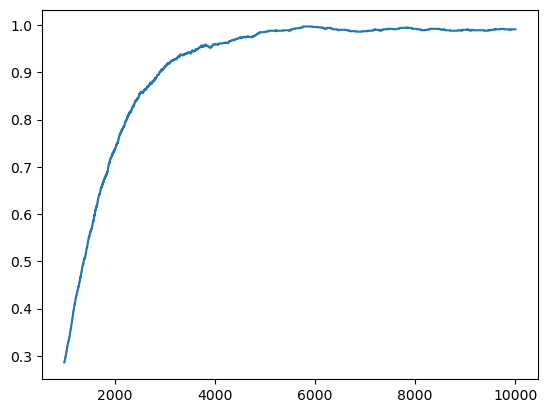

In [18]:
import matplotlib.pyplot as plt
plt.plot(np.arange(999, 10000), moving_average(rewards, 1000))
plt.show()

## Optimal policy

Let's print the q_table.

In [19]:
q_table

array([[0.94148015, 0.95099005, 0.93206535, 0.94148015],
       [0.94148015, 0.        , 0.90074647, 0.90860853],
       [0.6613915 , 0.96480805, 0.35176677, 0.4946806 ],
       [0.63312095, 0.        , 0.159837  , 0.0587711 ],
       [0.95099005, 0.96059601, 0.        , 0.94148015],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.98009996, 0.        , 0.85110797],
       [0.        , 0.        , 0.        , 0.        ],
       [0.96059601, 0.        , 0.970299  , 0.95099005],
       [0.96059597, 0.98009999, 0.9801    , 0.        ],
       [0.97029875, 0.99      , 0.        , 0.97029844],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.86221802, 0.99      , 0.9130117 ],
       [0.98009912, 0.98999998, 1.        , 0.98009962],
       [0.        , 0.        , 0.        , 0.        ]])

Let's use the learned q_table to define the policy. Name the method `policy`.

In [20]:
def policy(state): # remove
    return np.argmax(q_table[state])

Let's use an Enum to print out nicely which action to take in which state. 

In [21]:
class Action(Enum):

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3

In [22]:
for state in range(state_space_size):
    print("state: ", state, " action to take: ", Action(policy(state)).name)

state:  0  action to take:  DOWN
state:  1  action to take:  LEFT
state:  2  action to take:  DOWN
state:  3  action to take:  LEFT
state:  4  action to take:  DOWN
state:  5  action to take:  LEFT
state:  6  action to take:  DOWN
state:  7  action to take:  LEFT
state:  8  action to take:  RIGHT
state:  9  action to take:  RIGHT
state:  10  action to take:  DOWN
state:  11  action to take:  LEFT
state:  12  action to take:  LEFT
state:  13  action to take:  RIGHT
state:  14  action to take:  RIGHT
state:  15  action to take:  LEFT


Remember the surface looks as follows
 
 ```
        SFFF
        FHFH
        FFFH
        HFFG
 
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
```

It seems the best action to state in state 1 (upper left) is to go left. This might seem a strange choice. Why is this?

**answer** this is because the agent has learned that it goes down first it might end up somewhere where he didn't want to end up

## Play FrozenLake

Let's play FrozenLake for `num_episodes` times and check how well our learned policy does on average. How does it compare to your handcoded policy?

In [23]:
rewards_test = np.zeros(num_episodes)

for episode in range(num_episodes):
    state = env.reset()[0]
    for step in range(max_steps_per_episode):
        state, reward, terminated, truncated, info = env.step(policy(state))
        rewards_test[episode] += reward
        done = truncated or terminated 
        if done:
            break

In [24]:
np.mean(rewards_test)

1.0

If you want to play FrozenLake ones and see how the environment evolves you can run the following cells.

In [25]:
from IPython.display import clear_output
import time

In [26]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="human")
state = env.reset()[0]
print(env.render())
for step in range(max_steps_per_episode):
    time.sleep(0.1)
    clear_output(wait=True)
    action = policy(state)       
    state, reward, terminated, truncated, info = env.step(action)
    env.render()  
    done = truncated or terminated 
    if done:
        break

if state == 15:
    print("\nReached the goal 🏆")
else:
    print("\nFell into a hole ☠️")


Reached the goal 🏆


In [ ]:
env.close()

: 